# Lab Practice:  Stream Processing
Machine Learning 2 (Master's Degree in AI, UDC)

Authors:
1. Carlos Villar Martínez
1. Ovidio Manteiga Moar

## Problem description

The chosen problem consists in predicting the weather from weather data using this dataset https://www.kaggle.com/selfishgene/historical-hourly-weather-data)

The dataset contains some 5 years of high temporal resolution (hourly measurements) data of various weather attributes:

1. Temperature
1. Humidity
1. Pressure
1. Wind speed
1. Wind direction
1. Weather description

This data is available for 30 US and Canadian Cities, as well as 6 Israeli cities.
Each attribute has its own file and is organized such that the rows are the time axis (same time axis for all files), and the columns are the different cities (same city ordering for all files as well). Besides, for each city there is additional information of its country, latitude and longitude information in a separate file.

The possible weather descriptions are:

1. mist
1. broken clouds
1. sky is clear
1. light rain
1. few clouds
1. fog
1. overcast clouds
1. light intensity shower rain
1. moderate rain
1. light intensity drizzle
1. scattered clouds
1. proximity shower rain
1. heavy intensity rain
1. heavy snow
1. shower rain
1. snow
1. heavy shower snow
1. light intensity drizzle rain
1. light snow
1. very heavy rain
1. smoke
1. thunderstorm with heavy rain
1. light shower snow
1. haze
1. proximity thunderstorm
1. thunderstorm
1. heavy intensity drizzle
1. drizzle
1. thunderstorm with rain
1. thunderstorm with light rain
1. squalls
1. dust
1. proximity moderate rain
1. sand
1. sleet
1. proximity thunderstorm with drizzle
1. proximity thunderstorm with rain
1. thunderstorm with heavy drizzle
1. heavy intensity shower rain
1. shower snow
1. light rain and snow
1. thunderstorm with light drizzle
1. shower drizzle
1. freezing rain
1. light shower sleet
1. volcanic ash


### Problem specification

The first approach is predicting the current weather condition in a certain city given the other weather features. This is a supervised multiclass classification problem, since we will have the true classes corresponding to the weather description at each moment in time.

Another variant of the classification problem that can be more interesting for actual weather prediction consists of predicting the future weather based on the weather features from some previous days. This approach could also be more suitable for the stream learning approach, without needing to transform the dataset beforehand.

In [36]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

from river import feature_extraction, neighbors, metrics, preprocessing, stats, utils, stream, evaluate, compose, tree
from river.tree import HoeffdingTreeClassifier
from river.linear_model import LogisticRegression
from river import drift
from river import ensemble

## Prepare dataset

The dataset contains data from multiple cities, but for the purpose of this assignment, we only considered one of the cities, since there will be significant variations on the relationship between the weather variables across cities. For example, winds coming from the south in a city might bring humidity and clouds, while in another city might bring dry air and heat.

In [37]:

# Select the city to work with.
city = "New York"

dateset_path = "./dataset/"
csvs = ["humidity", "temperature", "pressure", "wind_speed", "wind_direction", "weather_description"]

new_df = pd.DataFrame()

# Read the CSV files into a dataframe.
for csv in csvs:
    csv_file = dateset_path + csv + ".csv"
    df = pd.read_csv(csv_file)
    city_col = df[city]
    new_df[csv] = city_col
    datetime_col = df["datetime"]
    new_df["datetime"] = datetime_col

# Removes rows with NaN.
new_df = new_df.dropna()
display(new_df)

# Assign the inputs and targets data frames.
inputs = new_df.iloc[:, 0:6]
inputs_with_times = inputs.copy()
inputs = inputs.drop(['datetime'], axis=1)
targets = new_df[['weather_description']]

# Check if the dataset is balanced
total_samples = len(targets)
print(f"Total samples = {total_samples}")
class_counts = targets.value_counts().to_frame(name="count")
class_counts["percentage"] = class_counts * 100 / total_samples

print(class_counts)
display(targets)

,humidity,datetime,temperature,pressure,wind_speed,wind_direction,weather_description
1,58.0,2012-10-01 13:00:00,288.220000,1012.0,7.0,260.0,few clouds
2,57.0,2012-10-01 14:00:00,288.247676,1012.0,7.0,260.0,few clouds
3,57.0,2012-10-01 15:00:00,288.326940,1012.0,7.0,260.0,few clouds
4,57.0,2012-10-01 16:00:00,288.406203,1012.0,7.0,260.0,few clouds
5,57.0,2012-10-01 17:00:00,288.485467,1012.0,6.0,261.0,few clouds
...,...,...,...,...,...,...,...
44456,36.0,2017-10-27 20:00:00,289.980000,1019.0,3.0,0.0,sky is clear
44457,38.0,2017-10-27 21:00:00,289.480000,1019.0,1.0,0.0,sky is clear
44458,54.0,2017-10-27 22:00:00,287.920000,1019.0,2.0,196.0,sky is clear
44459,62.0,2017-10-27 23:00:00,285.830000,1020.0,3.0,171.0,sky is clear


Total samples = 43609
                                     count  percentage
weather_description                                   
sky is clear                         11341   26.006100
broken clouds                         6142   14.084249
mist                                  5399   12.380472
scattered clouds                      4485   10.284574
overcast clouds                       4316    9.897040
light rain                            3947    9.050884
few clouds                            3267    7.491573
fog                                   1077    2.469674
moderate rain                          933    2.139467
haze                                   690    1.582242
light intensity drizzle                401    0.919535
light snow                             383    0.878259
heavy intensity rain                   369    0.846156
drizzle                                222    0.509069
heavy snow                             120    0.275173
proximity thunderstorm                 114 

,weather_description
1,few clouds
2,few clouds
3,few clouds
4,few clouds
5,few clouds
...,...
44456,sky is clear
44457,sky is clear
44458,sky is clear
44459,sky is clear


## Dataset analysis 

The classes are not balanced and there are very few samples for some of the most infrequent weather conditions.

The most frequent class for NYC is _sky is clear_ which represents more than 25% of the data, whereas the second most frequent class is _broken clouds_ with less than 15% of the samples. Also, there are many classes with only one or no samples.

Even though the dataset is unbalanced, since we are more interested in the predictions of the most common classes, no balancing techniques are applied. Besides there are a lot of classes with very little samples, so in order to make them more relevant for training, we might be losing some generality of the model where in actuality these clases represent very rare cases in the distribution. Moreover, for stream learning, we might be invalidating the aggreagate features any sort of downampling or upsampling is applied, for example when choosing rolling averages of a certain feature during the last 24 hours. 

### Metrics

Since the dataset is unbalanced, accuracy cannot be the only metric. In this case, we are using the F1 score as the metric to evaluate the models.

In this problem there is no clear preference of false positives over false negatives, so precision and recall are not to be used for deciding in case of similar F1 scores.

To be able to see also the accuracy, we are going to use the classification report alternatively in some of the executions.

In [38]:

# Defines the result of evaluating a model.

@dataclass
class ModelResult:
    name: str
    val_score: float
    val_score_std: float

# List of model results to be printed later.
model_results = []

# Adds a batch model result to the results.
def add_batch_result(name, scores):
    avg = scores['test_f1_weighted'].mean()
    std = scores['test_f1_weighted'].std()
    model_results.append(ModelResult("B/" + name, avg, std))

# Adds a stream model result to the results.
def add_stream_result(name, metric):
    model_results.append(ModelResult("S/" + name, metric.get(), 0))


## Batch models 

In [39]:

# Prepare inputs
X = inputs.copy()

# Prepare outputs
le = LabelEncoder()
le.fit(targets.to_numpy().ravel())
y = le.transform(targets.to_numpy().ravel())
transformed_targets = pd.DataFrame()
transformed_targets['weather_description'] = y

def cross_validate_model(a_model):
    # Configure and run cross-validation
    cross_validation = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(a_model, X, y, scoring=['accuracy', 'f1_weighted'], cv=cross_validation)
    # Display the average score and its standard deviation
    print(f"Accuracy: {scores['test_accuracy'].mean():.4f} (± {scores['test_accuracy'].std():.4f})")
    print(f"F1-weighted: {scores['test_f1_weighted'].mean():.4f} (± {scores['test_f1_weighted'].std():.4f})")
    return scores

### Hyper-parameter tuning

Hyper-parameter tuning is performed on the batch models to be later applied on the equivalent stream models in a similar fashion. For example, in the following cell, Different maximum depths for a decision tree are used to find the better one. 

In [40]:
for d in range(1,25):
    print(f"Max depth = {d}")
    pipe_dt2 = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', DecisionTreeClassifier(max_depth=d))
    ])
    scores = cross_validate_model(pipe_dt2)

Max depth = 1
Accuracy: 0.2881 (± 0.0100)
F1-weighted: 0.1597 (± 0.0069)
Max depth = 2
Accuracy: 0.3098 (± 0.0051)
F1-weighted: 0.2143 (± 0.0045)
Max depth = 3
Accuracy: 0.3120 (± 0.0057)
F1-weighted: 0.2210 (± 0.0069)
Max depth = 4
Accuracy: 0.3242 (± 0.0047)
F1-weighted: 0.2274 (± 0.0048)
Max depth = 5
Accuracy: 0.3296 (± 0.0061)
F1-weighted: 0.2420 (± 0.0060)
Max depth = 6
Accuracy: 0.3364 (± 0.0049)
F1-weighted: 0.2456 (± 0.0052)
Max depth = 7
Accuracy: 0.3417 (± 0.0051)
F1-weighted: 0.2676 (± 0.0058)
Max depth = 8
Accuracy: 0.3471 (± 0.0062)
F1-weighted: 0.2812 (± 0.0061)
Max depth = 9
Accuracy: 0.3527 (± 0.0071)
F1-weighted: 0.2949 (± 0.0115)
Max depth = 10
Accuracy: 0.3547 (± 0.0083)
F1-weighted: 0.3058 (± 0.0092)
Max depth = 11
Accuracy: 0.3595 (± 0.0081)
F1-weighted: 0.3184 (± 0.0091)
Max depth = 12
Accuracy: 0.3637 (± 0.0082)
F1-weighted: 0.3292 (± 0.0099)
Max depth = 13
Accuracy: 0.3631 (± 0.0067)
F1-weighted: 0.3345 (± 0.0071)
Max depth = 14
Accuracy: 0.3631 (± 0.0067)
F1-w

### Cross-validation of batch models

In [41]:
pipe_dt2 = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', DecisionTreeClassifier(max_depth=17))
])
scores = cross_validate_model(pipe_dt2)
add_batch_result("DT", scores)

Accuracy: 0.3683 (± 0.0062)
F1-weighted: 0.3579 (± 0.0071)


In [42]:
pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])
scores = cross_validate_model(pipe_knn)
add_batch_result("KNN", scores)

Accuracy: 0.3651 (± 0.0054)
F1-weighted: 0.3584 (± 0.0052)


In [43]:
pipe_ann = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', MLPClassifier([10,10], solver='adam', max_iter=500))
])
scores = cross_validate_model(pipe_ann)
add_batch_result("ANN", scores)

Accuracy: 0.3420 (± 0.0030)
F1-weighted: 0.2568 (± 0.0021)


In [44]:
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', RandomForestClassifier())
])
scores = cross_validate_model(pipe_rf)
add_batch_result("RF", scores)

Accuracy: 0.4637 (± 0.0073)
F1-weighted: 0.4457 (± 0.0071)


## Stream models

### Simple stream model

In [45]:

data = stream.iter_pandas(inputs, transformed_targets.iloc[:,0])

model = preprocessing.StandardScaler()
model |= neighbors.KNNClassifier()

metric = metrics.WeightedF1()
scores = evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)
add_stream_result("KNN", metric)

[10,000] WeightedF1: 49.82%
[20,000] WeightedF1: 48.59%
[30,000] WeightedF1: 46.97%
[40,000] WeightedF1: 46.49%


- KNN Classifier only: accuracy 42%
- KNN Classifier with scaler: accuracy 46% (reaches 50% at some checkpoints)

### Stream model with features and different scaling

After trying the first simple model, we applied feature engineering and data normalization to try to improve it.

The engineered features where rolling averages of the input features during the last 24 hours and 3 days. Considering some of the samples with incorrect data were removed from the dataset on preprocessing, using the last 24 samples is not guaranteed to use the last 24 hours of samples. For the purpose of this analysis we will assume this simplification, but we will try to improve it at the end of the notebook by using the datetime values instead.

As regards normalization, we applied min-max normalization to the wind direction attributes, since their values go from 0 to 360 degrees. But ideally, that value should be converted to a 2-dimensional vector with the sinus and cosinus of the value, so that the values close to 0 have a more similar representation to values close to 360 degrees. The rest of the attributes were standardized to zero mean and unit variance.

In [46]:

def get_aggregate_features_to_standardize():
    three_days = 3*24
    aggregates_to_standardize = feature_extraction.Agg(on='humidity', by=None, how=utils.Rolling(stats.Mean(), 24)) \
        + feature_extraction.Agg(on='temperature', by=None, how=utils.Rolling(stats.Mean(), 24)) \
        + feature_extraction.Agg(on='pressure', by=None, how=utils.Rolling(stats.Mean(), 24)) \
        + feature_extraction.Agg(on='wind_speed', by=None, how=utils.Rolling(stats.Mean(), 24))
    aggregates_to_standardize_3_days = ( \
        feature_extraction.Agg(on='humidity', by=None, how=utils.Rolling(stats.Mean(), three_days)) \
        + feature_extraction.Agg(on='temperature', by=None, how=utils.Rolling(stats.Mean(), three_days)) \
        + feature_extraction.Agg(on='pressure', by=None, how=utils.Rolling(stats.Mean(), three_days)) \
        + feature_extraction.Agg(on='wind_speed', by=None, how=utils.Rolling(stats.Mean(), three_days)) \
        ) | compose.Prefixer('3day_')
    return aggregates_to_standardize + aggregates_to_standardize_3_days

def get_standardized_features():
    feature_names_to_standardize = ['humidity', 'temperature', 'pressure', 'wind_speed']
    features_to_standardize = compose.Select(*feature_names_to_standardize) + get_aggregate_features_to_standardize()
    standardized = features_to_standardize | preprocessing.StandardScaler()
    return standardized

def get_normalized_features():
    three_days = 3*24
    aggregates_to_normalize = feature_extraction.Agg(on='wind_direction', by=None, how=utils.Rolling(stats.Mean(), 24)) \
        + feature_extraction.Agg(on='wind_direction', by=None, how=utils.Rolling(stats.Mean(), three_days))
    features_to_normalize = compose.Select('wind_direction') + aggregates_to_normalize 
    normalized = features_to_normalize | preprocessing.MinMaxScaler()
    return normalized

def get_all_features():
    return get_standardized_features() + get_normalized_features()


In [47]:

data = stream.iter_pandas(inputs, transformed_targets.iloc[:,0])

model = get_all_features()
model |= neighbors.KNNClassifier()

#metric = metrics.ClassificationReport()
metric = metrics.WeightedF1()
evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)

add_stream_result("KNN+F+S", metric)

[10,000] WeightedF1: 59.12%
[20,000] WeightedF1: 59.06%
[30,000] WeightedF1: 56.62%
[40,000] WeightedF1: 56.27%


### Stream model with Hoeffding tree

In [48]:

data = stream.iter_pandas(inputs, transformed_targets.iloc[:,0])

model = get_all_features()
model |= HoeffdingTreeClassifier()

#metric = metrics.ClassificationReport()
metric = metrics.WeightedF1() 
evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)

add_stream_result("HTC", metric)

[10,000] WeightedF1: 23.50%
[20,000] WeightedF1: 15.55%
[30,000] WeightedF1: 13.78%
[40,000] WeightedF1: 13.33%


### Concept drift

The data is subject to concept drift since it represents wheather data from 5 years, so there are already significant changes in the distribution of the input features and their relationship with the targets due to seasonal changes.

Moreover, long-term changes in the climate can also cause concept drift and also affect the model performance.

#### Data drift detection with ADWIN detector

humidity
Number of changes detected 364


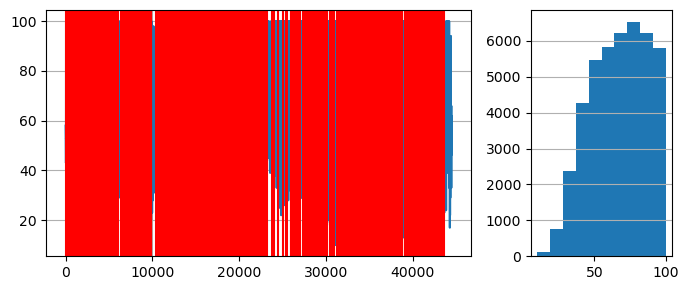

temperature
Number of changes detected 725


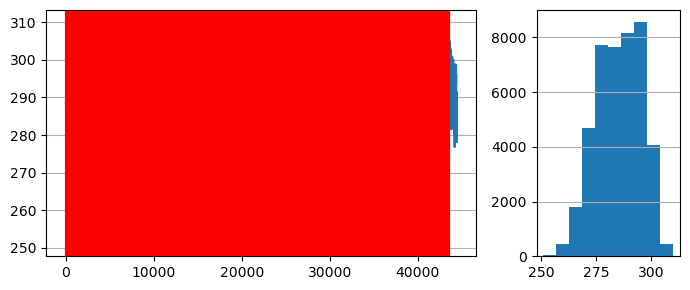

pressure
Number of changes detected 1228


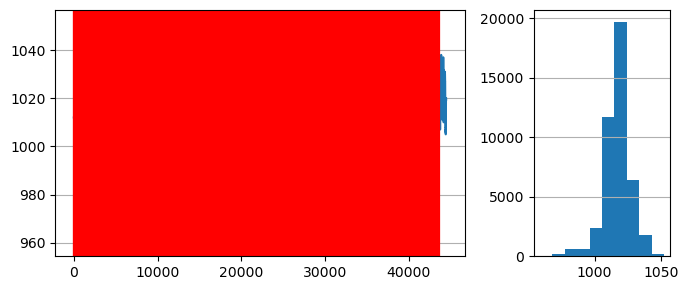

wind_speed
Number of changes detected 1444


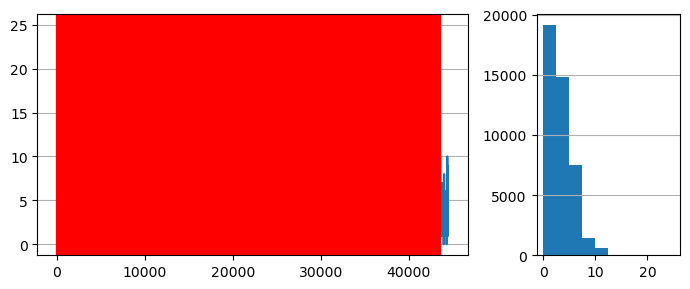

wind_direction
Number of changes detected 1798


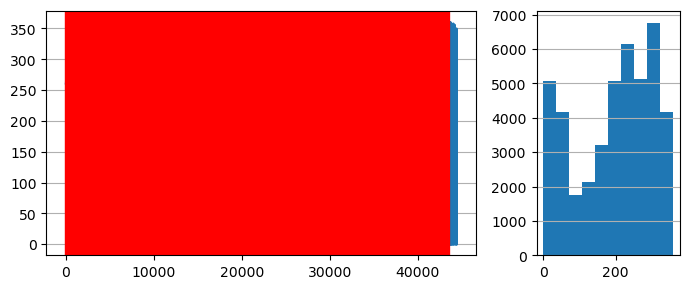

In [49]:

# Auxiliary function to analyse the data
def plot_data(stream_plot, dists, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream_plot, label='Stream')
    ax2.grid(axis='y')
    for id, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{id}')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()


drift_detector = drift.ADWIN()
drifts = []

for k in range(len(inputs.columns)):
    var_name = inputs.columns.values[k]
    print(var_name)
    data_stream = inputs.iloc[:,k] 
    for i, val in enumerate(data_stream):
        # Data is processed one sample at a time
        drift_detector.update(val)
        if drift_detector.drift_detected:
            # The drift detector indicates after each sample if there is a drift in the data
            # print(f'Change detected at index {i}')
            drifts.append(i)
    print(f'Number of changes detected {len(drifts)}')
    plot_data(data_stream, [inputs.iloc[:,k]], drifts)


In [50]:

data = stream.iter_pandas(inputs, transformed_targets.iloc[:,0])

# Model to use for detecting drifts in the model predictions.
model = preprocessing.StandardScaler()
model |= tree.ExtremelyFastDecisionTreeClassifier()

# We are waiting the first 100 observations before starting to analyze the drif
ddm = drift.EDDM(warm_start=100) 
# We similate the data stream with a loop
trigger_warning=True
i = 0
for xx, yy in data:
    # Make a prediction without using the target
    y_pred = model.predict_one(xx)
    # Update the model using the target
    model.learn_one(xx, yy)
    # Update the drift detector with the error.
    error = 0 if yy == y_pred else 1
    ddm.update(error)
    if ddm.warning_detected and trigger_warning:
        print(f"Warning detected at index {i}")
        # Once the threshod is overpassed, it is usually overpassed  during many iterations.
        trigger_warning=False
    if ddm.drift_detected:
        print(f"A drift was detected at index {i}")
        trigger_warning=True
    i += 1


A drift was detected at index 133
Warning detected at index 276
A drift was detected at index 6066
Warning detected at index 6221
A drift was detected at index 6240
Warning detected at index 6449
A drift was detected at index 6493
Warning detected at index 6613
A drift was detected at index 6701
Warning detected at index 6823
A drift was detected at index 6839
Warning detected at index 7009
A drift was detected at index 7041
Warning detected at index 7235
A drift was detected at index 7249
Warning detected at index 7399
A drift was detected at index 7416
A drift was detected at index 7562
Warning detected at index 7713
A drift was detected at index 7732
Warning detected at index 8132
A drift was detected at index 8161
Warning detected at index 8279
A drift was detected at index 8297
A drift was detected at index 8454
A drift was detected at index 8781
Warning detected at index 8914
A drift was detected at index 8925
A drift was detected at index 9446
A drift was detected at index 9753


### Adaptative Hoeffding tree

In [51]:

data = stream.iter_pandas(inputs, transformed_targets.iloc[:,0])

model = get_all_features()
model |= tree.HoeffdingAdaptiveTreeClassifier(max_depth=17)

#metric = metrics.ClassificationReport()
metric = metrics.WeightedF1()

evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)

add_stream_result("AHTC", metric)


[10,000] WeightedF1: 23.45%
[20,000] WeightedF1: 15.45%
[30,000] WeightedF1: 13.73%
[40,000] WeightedF1: 13.30%


### Binary problem

Seeing the complexity of the multiclass problem with so many classes, we also tried a variant of the problem where we joined multiple classes into two in order to be able to predict good or bad weather.

In [52]:

good_weather = ['sky is clear', 'broken clouds', 'scattered clouds', 'few clouds']
good_weather_ints = le.transform(good_weather)
print(good_weather_ints)

binary_targets = transformed_targets.copy()

binary_targets['weather_description'] = 'bad'
for good_weather_int in good_weather_ints:
    binary_targets.loc[transformed_targets['weather_description'] == good_weather_int] = 'good'

display(binary_targets)


[26  0 24  3]


,weather_description
0,good
1,good
2,good
3,good
4,good
...,...
43604,good
43605,good
43606,good
43607,good


In [54]:

data = stream.iter_pandas(inputs, binary_targets.iloc[:,0])

model = get_all_features()
model |= neighbors.KNNClassifier()

#metric = metrics.ClassificationReport()
metric = metrics.WeightedF1()

evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)

add_stream_result("BIN/KNN", metric)


[10,000] WeightedF1: 86.29%
[20,000] WeightedF1: 85.44%
[30,000] WeightedF1: 84.51%
[40,000] WeightedF1: 84.59%


In [55]:

data = stream.iter_pandas(inputs,  binary_targets.iloc[:,0])

model = get_all_features()
model |= tree.HoeffdingAdaptiveTreeClassifier()

#metric = metrics.ClassificationReport()
metric = metrics.WeightedF1() 

evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)

add_stream_result("BIN/AHTC", metric)

[10,000] WeightedF1: 77.27%
[20,000] WeightedF1: 75.52%
[30,000] WeightedF1: 75.37%
[40,000] WeightedF1: 74.75%


### Ensemble models

In [56]:

data = stream.iter_pandas(inputs, binary_targets.iloc[:,0])

submodel = get_all_features()
submodel |= tree.HoeffdingAdaptiveTreeClassifier()

model = ensemble.ADWINBaggingClassifier(model=submodel)

#metric = metrics.ClassificationReport()
metric = metrics.WeightedF1() 

evaluate.progressive_val_score(dataset=data, model=model, metric=metric, print_every=10_000)

add_stream_result("BIN/ABC", metric)

[10,000] WeightedF1: 78.23%
[20,000] WeightedF1: 77.37%
[30,000] WeightedF1: 77.07%
[40,000] WeightedF1: 76.83%


## Model comparison

#: Model 	 Weighted F1 %
1: B/DT 	 35.79%
2: B/KNN 	 35.84%
3: B/ANN 	 25.68%
4: B/RF 	 44.57%
5: S/KNN 	 46.26%
6: S/KNN+F+S 	 55.82%
7: S/HTC 	 13.95%
8: S/AHTC 	 15.36%
9: S/BIN/KNN 	 84.43%
10: S/BIN/AHTC 	 74.94%
11: S/BIN/ABC 	 77.05%


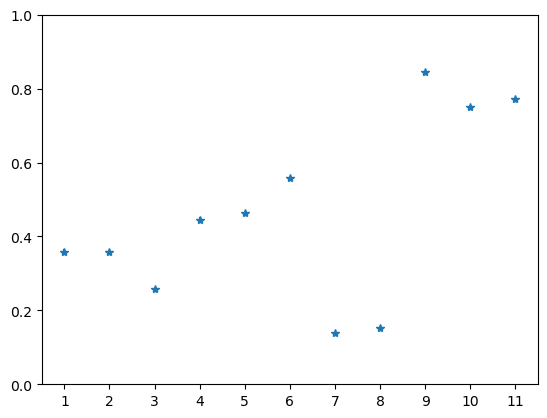

In [69]:
numbers = []
names = []
avgs = []
stds = []
i = 1
for model_result in model_results:
    numbers.append(f"{i}")
    names.append(model_result.name)
    avgs.append(model_result.val_score)
    stds.append(model_result.val_score_std)
    i += 1
print(f'#: Model \t Weighted F1 %')
for i in range(len(numbers)):
    score = "{:.2f}".format(avgs[i]*100)
    print(f'{numbers[i]}: {names[i]} \t {score}%')
plt.errorbar(numbers, avgs, stds, linestyle='None', marker='*', ecolor='red')
plt.ylim([0, 1])
plt.show()

## Models with date time

In [ ]:
# Does not work

import datetime as dt

def transform_to_date(x):
    return dt.datetime.fromisoformat(x["datetime"])

def get_date(x):
    return { "datetime": dt.datetime.fromisoformat(x["datetime"]) }

data = stream.iter_pandas(inputs, transformed_targets.iloc[:,0])

date = compose.Select('datetime') | get_date 
agg = feature_extraction.Agg(on="humidity", by=None, how=utils.TimeRolling(stats.Mean(), period=dt.timedelta(days=3)))
rest = compose.Discard('datetime') | preprocessing.StandardScaler()
model = date + agg + rest
model |= tree.ExtremelyFastDecisionTreeClassifier()

#x, y = next(iter(data))
#print(model.debug_one(x))
evaluate.progressive_val_score(dataset=data, model=model, metric=metrics.WeightedF1(),
                print_every=10_000, moment=transform_to_date, delay=dt.timedelta(0))


## Conclusions and Future Work

### Conclusions

1. The accuracy and f1 score of the batch models and the stream models of the multiclass classification problem are very low, even using the adaptative stream models. Although there are a lot of classes and the percentage of values of the most frequent class is 26%.
    1. Best weighted F1 score batch: Random Forest around 44%.
    1. Best weighted F1 score stream: KNN with features and scaling around 55%.
1. The binary classification problem the accuracy and weighted f1 scores are much higher.
    1. Best weighted F1 score close to 85% corresponds to the stream model with the KNN classifier. 
1. The engineered features improved the metrics significantly (around 10% more).
1. The hypeparameter tuning did not significantly improve the stream models.
1. The drift detectors detect too many drifts both in the data and the predicted values. It could be related to the poor performance of the models.
1. The adaptative models performed very badly, probably due to the underlying drift detectors detecting too many drifts so that the model was adapting too often without time to learn to predict the temporal values.

### Future Work

1. Use forecasting models instead of nowcasting to predict the future weather.
1. Use date-time for the rolling averages instead of a certain number of samples.
1. Use upsampling/downsampling to compensate for the unbalanced classes.
1. Use a holdout of the dataset to evaluate the batch models with unseen data to see assess the fairness of the comparison using cross-validation scores.
1. Add engineered features to the batch models.
